# Data Mining: 4502

## Chicago Crime vs Max Temperature

---

### Team Members:
- **Shrey Shah** — `shsh7331`
- **Patrick Ridley** — `pa8094`

# Chicago Crime vs Weather

This code review focuses on a **data-driven analysis project** that explores the relationship between **violent crime rates** and **weather conditions** in Chicago.

Leveraging publicly available datasets on **daily crime reports** and **weather statistics** from **2008 to 2024**, the goal of this project is to investigate whether **temperature fluctuations**—particularly extremes in daily high (**TMAX**) and low (**TMIN**) temperatures—**correlate with patterns in crime occurrences**.

---

### Focus Areas
- **Data Integration Process**: Merging crime and weather datasets accurately.
- **Data Cleaning Procedures**: Handling missing values, standardizing formats.
- **SQL and Python Scripting**: Querying, processing, and analyzing large datasets.
- **Visualization Techniques**: Building clear, insightful graphs and statistical outputs.

---

Special attention is given to:
- **Preprocessing methods** used to clean the data,
- **Joining datasets** accurately based on date,
- **Generating meaningful trends** through statistical summaries and graphical outputs.

This introduction sets the stage for a **deep dive** into the **logic, accuracy, and efficiency** of the code implementations supporting the full analytical workflow.

# Crime Frequency Analysis by Type

To support our analysis of crime patterns in relation to weather in Chicago, the project required importing two large datasets into a MySQL database: **historical crime records** and **daily weather observations**.

The Chicago crime dataset, containing **millions of rows**, was imported using **MySQL Workbench’s Table Data Import Wizard**.  
- Due to the sheer volume of data, the import process took **over 10 hours** to complete.

In contrast, the **weather dataset** posed different challenges:
- Although smaller in size, it contained inconsistencies in formatting and missing data that the wizard could not handle correctly.

---

## Handling the Weather Dataset

To address these issues:
- The **weather table schema** was modified to allow for `NULL` values in critical fields like `TMAX` and `TMIN`, which were originally set to `NOT NULL`.
- This allowed missing temperature values to be properly identified and handled.

The data was imported using a **`LOAD DATA LOCAL INFILE`** command in SQL, using the `NULLIF` function to ensure blank fields were treated as `NULL` rather than defaulting to zero — preserving dataset integrity.

---

## Original Table Schema

```sql
CREATE TABLE weather_data (
    Date DATE NOT NULL,
    TAVG FLOAT,
    TMAX FLOAT NOT NULL,
    TMIN FLOAT NOT NULL,
    PRCP FLOAT,
    SNOW FLOAT,
    SNWD FLOAT
);Crime Frequency Analysis by Type:

To support our analysis of crime patterns in relation to weather in Chicago, the project required importing two large datasets into a MySQL database: historical crime records and daily weather observations. The Chicago crime dataset, which contains millions of rows, was imported using MySQL Workbench’s Table Data Import Wizard. Due to the sheer volume of data, the import process took over 10 hours to complete. In contrast, the weather dataset posed different challenges. Although smaller in size, it contained inconsistencies in formatting and missing data that the wizard could not handle correctly.

To address this, the weather table schema was modified to allow for NULL values in critical fields like TMAX and TMIN, which were originally set to NOT NULL. This change enabled a more accurate import process where missing temperature values could be properly identified and handled. The data was then imported using a LOAD DATA LOCAL INFILE command in SQL, accompanied by the NULLIF function to ensure blank fields were correctly treated as NULL rather than defaulting to zero—thus preserving the integrity of the dataset for later analysis.

This is how it was orginally created.
CREATE TABLE weather_data (
    Date DATE NOT NULL,
    TAVG FLOAT,
    TMAX FLOAT NOT NULL,
    TMIN FLOAT NOT NULL,
    PRCP FLOAT,
    SNOW FLOAT,
    SNWD FLOAT
);

This is what i had to do to correct the imports

ALTER TABLE weather_data 
MODIFY COLUMN TMAX INT NULL,

MODIFY COLUMN TMIN INT NULL;

This is how i imported it:  

LOAD DATA LOCAL INFILE '/Users/patrickridley/Documents/Weather_dataset.csv'
INTO TABLE weather_data
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\n'
IGNORE 1 ROWS
(Date, TAVG, TMAX, TMIN, PRCP, SNOW, SNWD)
SET 
    TAVG = NULLIF(TAVG, ''), 
    TMAX = NULLIF(TMAX, ''), 
    TMIN = NULLIF(TMIN, ''), 
    PRCP = NULLIF(PRCP, ''), 
    SNOW = NULLIF(SNOW, ''), 
    SNWD = NULLIF(SNWD, '');

# Crime Frequency Analysis by Primary Type

The following code plays a **foundational role** in our exploratory data analysis by querying the Chicago crime database to determine the **overall frequency of each crime category**.

By visualizing this data in a **horizontal bar chart**, we are able to quickly identify which types of offenses dominate the city's crime reports — an important step before attempting deeper analytical correlations with external factors such as **temperature** or **seasonality**.

---

## SQL Query

The SQL query aggregates crime data by the `Primary Type` column from the `chi_crime` table:
- Each crime incident (e.g., theft, battery, assault) is categorized under this field.
- The query returns a **ranked count** of each crime type, ordered by descending frequency.

The results are pulled into a **Pandas DataFrame** and visualized using **Seaborn**, a Python data visualization library built on top of **Matplotlib**.

---

## Key Observations

- The resulting chart provides a **visual overview** of crime types.
- **Theft**, **battery**, and **criminal damage** appear as the **most frequent offenses**.
- **Battery**, a violent crime, holds **particular importance** for our later analysis of temperature relationships.
- Other violent crime types of interest — such as **assault**, **homicide**, and **sexual offenses** — are also highlighted through this distribution.

---

## Importance for Further Analysis

This bar chart not only **validates the richness** of our dataset but also:
- Helps **refine** which crimes should be isolated for deeper analysis (trend, clustering, or correlation studies).
- Provides **critical framing** for understanding crime trends and setting analytical priorities for the rest of the project.

✅ Connected to MySQL database successfully!


/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/3330707446.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/3330707446.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df["Primary Type"], x=df["Crime_Count"], palette="viridis")


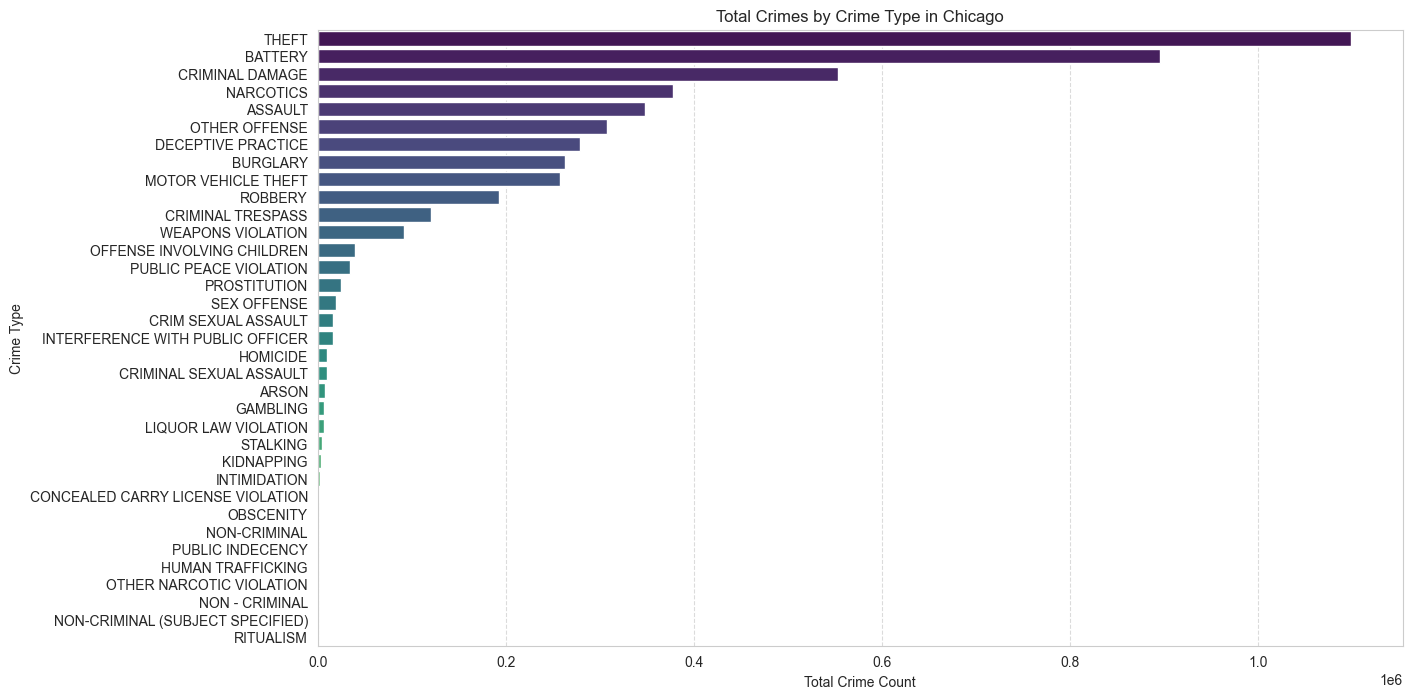

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL
try:
    conn = mysql.connector.connect(**DB_CONFIG)
    print("Connected to MySQL database successfully!")
except mysql.connector.Error as err:
    print(f"Error: {err}")
    exit()

# SQL Query to fetch total crime count per type
query = """
    SELECT `Primary Type`, COUNT(*) AS Crime_Count
    FROM chi_crime
    GROUP BY `Primary Type`
    ORDER BY Crime_Count DESC;
"""

# Fetch data into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Close database connection
conn.close()

# Set up the visualization
plt.figure(figsize=(14, 8))
sns.barplot(y=df["Primary Type"], x=df["Crime_Count"], palette="viridis")

# Add labels and title
plt.xlabel("Total Crime Count")
plt.ylabel("Crime Type")
plt.title("Total Crimes by Crime Type in Chicago")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

# Time Series Visualization of Maximum Daily Temperature in Chicago

The following Python script visualizes the **total number of reported crimes** in Chicago **aggregated by month** across the calendar year.  
This **line chart** is particularly useful for identifying **seasonal or cyclic crime patterns**, which are essential when exploring potential correlations between **weather** and **crime behavior**.

---

## Data Extraction

Using **SQL**, the script extracts crime counts grouped by the month (`MONTH(adjDate)`):
- Ensures that only entries with **valid, cleaned date values** (`adjDate IS NOT NULL`) are included.
- The data is retrieved into a **Pandas DataFrame** for further visualization.

---

## Visualization

- **Seaborn’s** `lineplot` is used to illustrate monthly crime trends.
- Each point on the graph is **marked** for clarity.
- The x-axis is labeled with intuitive **month abbreviations** (e.g., **Jan, Feb, Mar**) to enhance readability.

---

## Key Observations

- **Higher crime counts** are observed during the **warmer months** (typically **May through September**).
- This trend aligns with sociological and criminological research suggesting:
  - Increased temperatures can **elevate stress levels**.
  - More **outdoor activities** and **social interactions** occur, potentially leading to more crime.
- **Colder months** show a **noticeable dip** in crime, likely due to reduced mobility and fewer public gatherings.

---

## Importance for Further Analysis

This **monthly trend analysis** serves as a foundation for deeper investigations, such as:
- **Layering temperature data** on top of crime patterns.
- **Exploring specific crime types** (e.g., **assaults**, **homicides**) to assess whether their frequency **fluctuates in tandem** with seasonal weather conditions.

✅ Connected to MySQL database successfully!


/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/3017559974.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


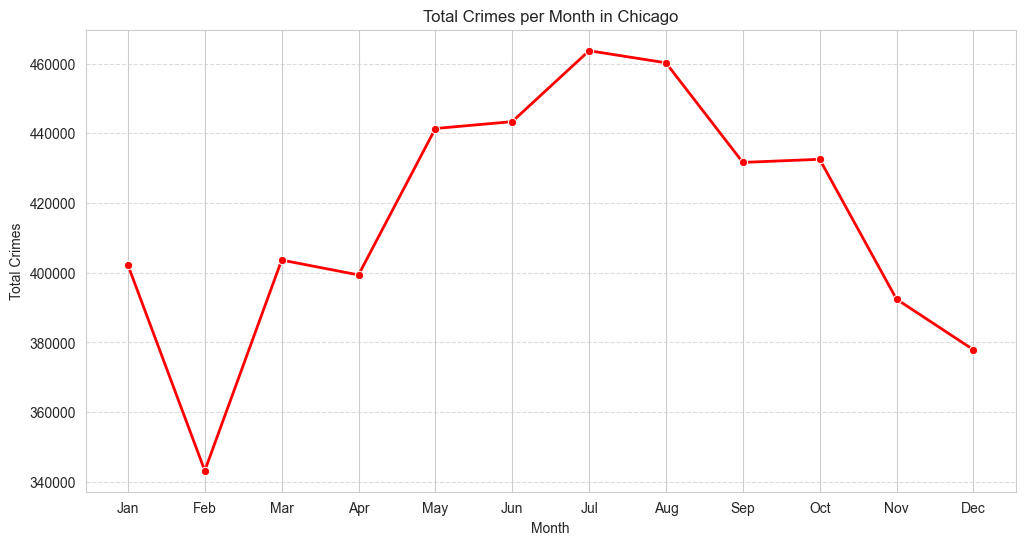

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL
try:
    conn = mysql.connector.connect(**DB_CONFIG)
    print("Connected to MySQL database successfully!")
except mysql.connector.Error as err:
    print(f"Error: {err}")
    exit()

# SQL Query: Count crimes per month
query = """
    SELECT MONTH(adjDate) AS Month, COUNT(*) AS Crime_Count
    FROM chi_crime
    WHERE adjDate IS NOT NULL
    GROUP BY Month
    ORDER BY Month;
"""

# Fetch data into Pandas DataFrame
df = pd.read_sql(query, conn)

# Close database connection
conn.close()

# Month labels for better readability
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df["Month"] = df["Month"].astype(int)  # Ensure month is integer

# Set up visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["Month"], y=df["Crime_Count"], marker="o", linewidth=2, color="red")

# Format the chart
plt.xticks(ticks=range(1, 13), labels=month_labels)
plt.xlabel("Month")
plt.ylabel("Total Crimes")
plt.title("Total Crimes per Month in Chicago")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [ ]:
%pip install mysql-connector-python pandas matplotlib seaborn
%pip install statsmodels


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 47.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 104.6 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Time Series Visualization of Maximum Daily Temperature in Chicago

The following script creates a **time series plot** of **maximum daily temperatures (TMAX)** recorded in Chicago over the past two decades.

This visualization serves two key purposes:
1. **Capturing the seasonal weather patterns** that cycle consistently throughout each year.
2. **Verifying the accuracy and integrity** of the imported weather dataset following the custom data-cleaning process.

---

## Data Extraction

- The script queries the `weather_data` table from the `chicago_crime` database.
- It selects only rows where `TMAX` is **not null**.
- Using **Pandas**, the data is pulled into a DataFrame and the `Date` column is properly converted into `datetime` format.

---

## Visualization

- A **Matplotlib** line plot is generated to show how daily maximum temperatures vary across the years.
- The output chart captures clear **seasonal cycles**:
  - **High temperatures in summer**.
  - **Low temperatures in winter**.

---

## Key Observations

- The plot confirms **consistent climatic seasonality** in Chicago.
- Early in the project, this visualization helped uncover a critical **data quality issue**:
  - **Temperature values of 0°F** in mid-July were discovered, which are **highly unlikely** for Chicago.
  - These erroneous entries were traced back to **improperly parsed missing values** during the initial CSV import.

---

## Data Cleaning Approach

- Unlike the crime dataset (imported via MySQL Workbench), the weather dataset was handled **through a dedicated Python script**.
- The script:
  - Identified and removed rows with missing or empty `TMAX`, `TMIN`, or `Date` fields.
  - Ensured only **valid and complete records** were retained before loading into MySQL.

---

## Importance for Analysis

Although the erroneous values have been removed, this visualization continues to serve as a **sanity check** confirming:
- **Temperature trends behave as expected**.
- **Dataset reliability** for subsequent analysis exploring the relationship between **weather patterns and violent crime occurrences** in Chicago.

✅ Connected to MySQL database successfully!


/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/1446480264.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


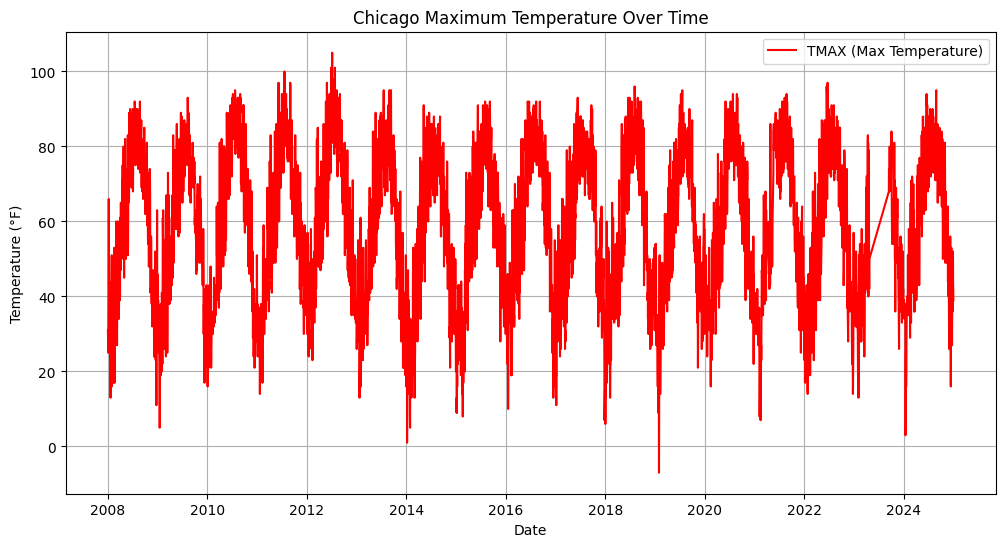

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL
try:
    conn = mysql.connector.connect(**DB_CONFIG)
    print("Connected to MySQL database successfully!")
except mysql.connector.Error as err:
    print(f"Error: {err}")

# Connect to MySQL
conn = mysql.connector.connect(**DB_CONFIG)
query = "SELECT Date, TMAX FROM weather_data WHERE TMAX IS NOT NULL ORDER BY Date;"
df = pd.read_sql(query, conn)
conn.close()

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["TMAX"], label="TMAX (Max Temperature)", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.title("Chicago Maximum Temperature Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Merging Crime and Weather Data for OLAP Analysis

To perform more advanced analytical operations using **OLAP techniques**, we merged **cleaned and filtered crime data** with corresponding **daily weather observations**.

The goal was to:
- **Isolate violent crime categories** (such as assaults, batteries, homicides, and sex-related offenses).
- **Align crime incidents by date** with daily high (`TMAX`) and low (`TMIN`) temperatures.
- Facilitate **multidimensional analysis** by creating a unified dataset.

---

## Integration Process

This integration was executed directly in **MySQL Workbench** and involved two primary steps:

1. **Table Creation**:
   - A new table `crime_weather_data` was created to store merged daily data, including:
     - Date
     - Maximum Temperature (`TMAX`)
     - Minimum Temperature (`TMIN`)
     - Total Crime Count
     - Assault Count
     - Battery Count
     - Homicide Count
     - Sex-related Crime Count

2. **Data Population**:
   - Data was merged using a **LEFT JOIN** operation matching `weather_data.Date = chi_crime.adjDate`.
   - Daily aggregation queries were used to count the number of each type of violent crime.

---

By creating this integrated dataset, we established a **solid foundation** for performing OLAP operations such as:
- **Slicing** data by date ranges or temperature bands.
- **Dicing** data by crime types or severity.
- **Rolling up** data into monthly, seasonal, or annual summaries for trend analysis.

This merged structure allowed us to explore the relationship between **temperature fluctuations** and **violent crime occurrences** with greater clarity and analytical power.

We began by creating a new table, crime_weather_data, which serves as a centralized structure for storing merged information. This table was designed to hold daily temperature data alongside counts of violent crime types:

CREATE TABLE crime_weather_data (
    Date DATE NOT NULL PRIMARY KEY,
    TMAX INT NOT NULL,
    TMIN INT NOT NULL,
    Crime_Count INT NOT NULL,
    Assault_Count INT NOT NULL,
    Battery_Count INT NOT NULL,
    Homicide_Count INT NOT NULL,
    Sex_Crime_Count INT NOT NULL
);

Using a LEFT JOIN on the weather data and crime table (chi_crime), we aggregated counts of specific violent crime types by date. The join condition matched dates from the weather data (Date) to adjusted crime dates (adjDate). Only records with valid (non-null) TMAX and TMIN values were considered to maintain data integrity.

INSERT INTO crime_weather_data (Date, TMAX, TMIN, Crime_Count, Assault_Count, Battery_Count, Homicide_Count, Sex_Crime_Count)
SELECT 
    w.Date, 
    w.TMAX, 
    w.TMIN, 
    COUNT(c.ID) AS Crime_Count, 
    SUM(CASE WHEN c.`Primary Type` = 'ASSAULT' THEN 1 ELSE 0 END) AS Assault_Count,
    SUM(CASE WHEN c.`Primary Type` = 'BATTERY' THEN 1 ELSE 0 END) AS Battery_Count,
    SUM(CASE WHEN c.`Primary Type` = 'HOMICIDE' THEN 1 ELSE 0 END) AS Homicide_Count,
    SUM(CASE WHEN c.`Primary Type` IN ('SEX OFFENSE', 'CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'OFFENSE INVOLVING CHILDREN') THEN 1 ELSE 0 END) AS Sex_Crime_Count
FROM weather_data w
LEFT JOIN chi_crime c 
    ON w.Date = c.adjDate
WHERE w.TMAX IS NOT NULL AND w.TMIN IS NOT NULL
GROUP BY w.Date, w.TMAX, w.TMIN;

The resulting crime_weather_data table forms the foundation for visualizations, trend analysis, and hypothesis testing throughout the remainder of the project. With each row representing one day, and containing both weather metrics and violent crime counts, this merged dataset enables effective application of OLAP techniques, such as slicing by date or temperature range, and rolling up to seasonal summaries.

# Visualizing the Relationship Between Temperature and Violent Crime

To explore the relationship between weather patterns and violent crime in Chicago, we created a layered scatter plot that visualizes four major categories of violent crime—assaults, battery, homicides, and sex crimes—against daily maximum temperatures (TMAX). 

The data used for this visualization was pulled from a merged table, `crime_weather_data`, which combines weather and crime data by date. Each crime type is represented as a series of points across the temperature axis, allowing us to observe how often different crimes occur at specific temperature ranges. 

The scatter plot, created using Seaborn in Python, uses semi-transparent points (`alpha=0.6`) to show overlapping incidents while maintaining clarity in visual density.

---

## Key Observations

The resulting chart offers an exploratory view into how temperature may influence criminal activity. While noise is expected due to day-to-day variation, a trend begins to emerge—**warmer temperatures tend to correlate with higher occurrences of certain violent crimes**, especially **assaults** and **battery**. 

These categories show denser clusters between approximately **50°F and 90°F**. Although this visualization alone doesn’t prove causation, it supports hypotheses discussed in existing literature, such as the **“heat hypothesis,”** which suggests increased aggression and outdoor activity during warmer weather may lead to more interpersonal conflict.

This initial visual analysis lays the groundwork for further statistical and predictive modeling to confirm the strength and significance of this observed relationship.

         Date  TMAX  TMIN  Crime_Count  Assault_Count  Battery_Count  \
0  2008-01-01    31    10         1832             63            303   
1  2008-01-02    26     6          919             44            112   
2  2008-01-03    25     8          916             33            126   
3  2008-01-04    37    25         1099             57            154   
4  2008-01-05    45    37         1183             61            191   

   Homicide_Count  Sex_Crime_Count  
0               2              199  
1               1               13  
2               1               10  
3               1               16  
4               2               15  


/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/2305868975.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


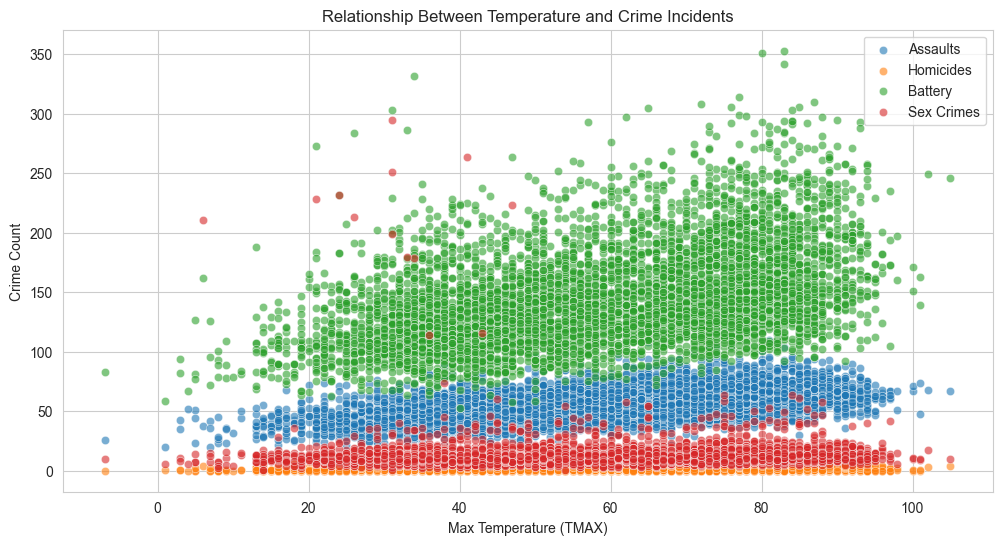

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL
conn = mysql.connector.connect(**DB_CONFIG)

# SQL query to fetch crime and weather data
query = """
    SELECT Date, TMAX, TMIN, Crime_Count, Assault_Count, Battery_Count, Homicide_Count, Sex_Crime_Count
    FROM crime_weather_data
    WHERE TMAX IS NOT NULL AND TMIN IS NOT NULL
    ORDER BY Date;
"""

# Load data into a Pandas DataFrame
df = pd.read_sql(query, conn)
conn.close()

# Check the first few rows of data
print(df.head())

# Set the plot style
sns.set_style("whitegrid")

# Create a scatter plot showing the relationship between TMAX (Max Temperature) and various crime types
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df["TMAX"], y=df["Assault_Count"], label="Assaults", alpha=0.6)
sns.scatterplot(x=df["TMAX"], y=df["Homicide_Count"], label="Homicides", alpha=0.6)
sns.scatterplot(x=df["TMAX"], y=df["Battery_Count"], label="Battery", alpha=0.6)
sns.scatterplot(x=df["TMAX"], y=df["Sex_Crime_Count"], label="Sex Crimes", alpha=0.6)

# Add labels and title
plt.xlabel("Max Temperature (TMAX)")
plt.ylabel("Crime Count")
plt.title("Relationship Between Temperature and Crime Incidents")
plt.legend()
plt.show()

# Linear Relationship Between Temperature and Total Violent Crime Incidents in Chicago

This visualization builds on the previous analysis by combining four key categories of violent crime—assaults, battery, homicides, and sex-related offenses—into a single metric: **Total Violent Crime**.

Using the merged `crime_weather_data` table, the script plots each day’s maximum temperature (`TMAX`) against the total number of violent crimes committed on that day. The result is a scatter plot that captures the overall relationship between heat and violent behavior across many years of data.

---

## Visualization Approach

To better illustrate potential correlations, the chart includes a **linear trend line**, generated using Seaborn’s `regplot` function.  
This line estimates the general direction of the relationship between temperature and violent crime, helping smooth out the noise in day-to-day variability.

The **positive slope** of the red trend line suggests that **higher temperatures are generally associated with an increase in total violent crime**, supporting hypotheses in criminology and behavioral science about heat’s impact on aggression and social interactions.

---

## Importance of This Analysis

By visualizing the aggregated crime data in this way, the plot offers a **simplified but compelling summary** of the overall trend, and serves as a useful foundation for deeper statistical testing (e.g., correlation coefficients or regression modeling).

It’s particularly valuable in showcasing how combining multiple crime categories can help clarify broader environmental-crime patterns that might be **less obvious** when viewing categories individually.

         Date  TMAX  TMIN  Total_Violent_Crime
0  2008-01-01    31    10                  567
1  2008-01-02    26     6                  170
2  2008-01-03    25     8                  170
3  2008-01-04    37    25                  228
4  2008-01-05    45    37                  269


/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/2667610434.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


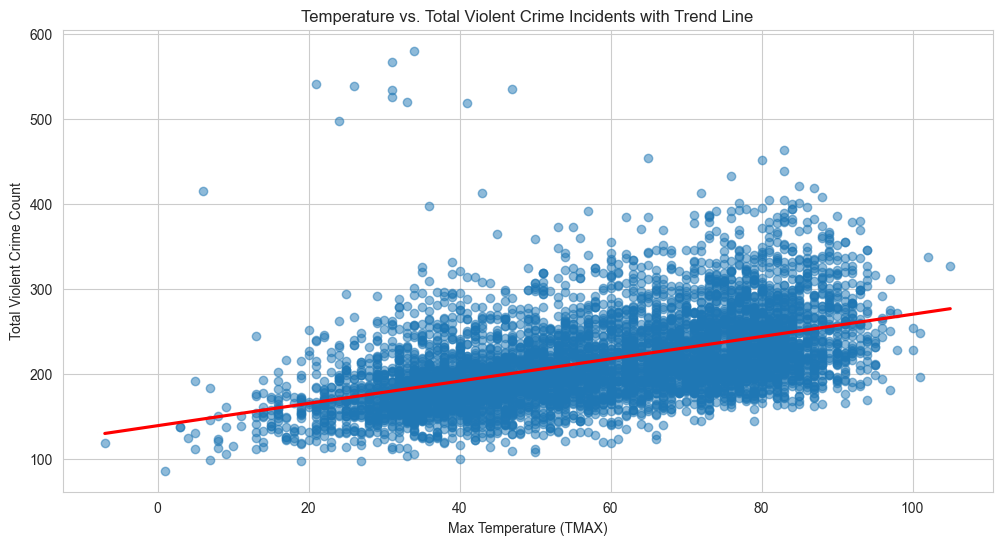

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL
conn = mysql.connector.connect(**DB_CONFIG)

# SQL query to fetch data from the merged crime_weather_data table
query = """
    SELECT Date, TMAX, TMIN, 
           (Assault_Count + Battery_Count + Homicide_Count + Sex_Crime_Count) AS Total_Violent_Crime
    FROM crime_weather_data
    WHERE TMAX IS NOT NULL AND TMIN IS NOT NULL
    ORDER BY Date;
"""

# Load data into a Pandas DataFrame
df = pd.read_sql(query, conn)
conn.close()

# Check the first few rows
print(df.head())

# Set the plot style
sns.set_style("whitegrid")

# Create a scatter plot with a trend line
plt.figure(figsize=(12, 6))
sns.regplot(x=df["TMAX"], y=df["Total_Violent_Crime"], scatter=True, 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, ci=None)

# Add labels and title
plt.xlabel("Max Temperature (TMAX)")
plt.ylabel("Total Violent Crime Count")
plt.title("Temperature vs. Total Violent Crime Incidents with Trend Line")

# Show the plot
plt.show()

# Upside Down U-Shaped Trend of Violent Crime Across Temperature Ranges

The following script creates a bar chart that analyzes how total violent crime varies with temperature, specifically examining daily high temperatures (`TMAX`).

After retrieving and filtering data from the `crime_weather_data` table, the code groups the temperatures into **5-degree bins** using `pandas.cut()`.  
This allows for aggregated analysis of crime patterns across discrete temperature ranges.

---

## Visualization Approach

Each bar on the chart represents the total number of violent crimes—comprising **assaults**, **batteries**, **homicides**, and **sex crimes**—recorded on days within a specific temperature range.

The resulting visualization reveals a subtle **inverted U-shaped pattern**:
- Violent crime counts tend to **increase** as temperatures rise to **moderate or warm levels** (around **70–85°F**).
- Crime counts **decrease again** at higher extremes.

---

## Theoretical Context

This pattern supports research theories such as the **Heat Hypothesis** (Anderson, 1989), which suggests that:
- Warmer weather increases **social interaction** and **agitation**, potentially leading to more violence.
- However, excessively hot days may **reduce activity**, leading to **fewer incidents**.

/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/558203741.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/558203741.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime_by_temp = df.groupby("Temp_Range")["Total_Violent_Crime"].sum().reset_index()
/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/558203741.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=

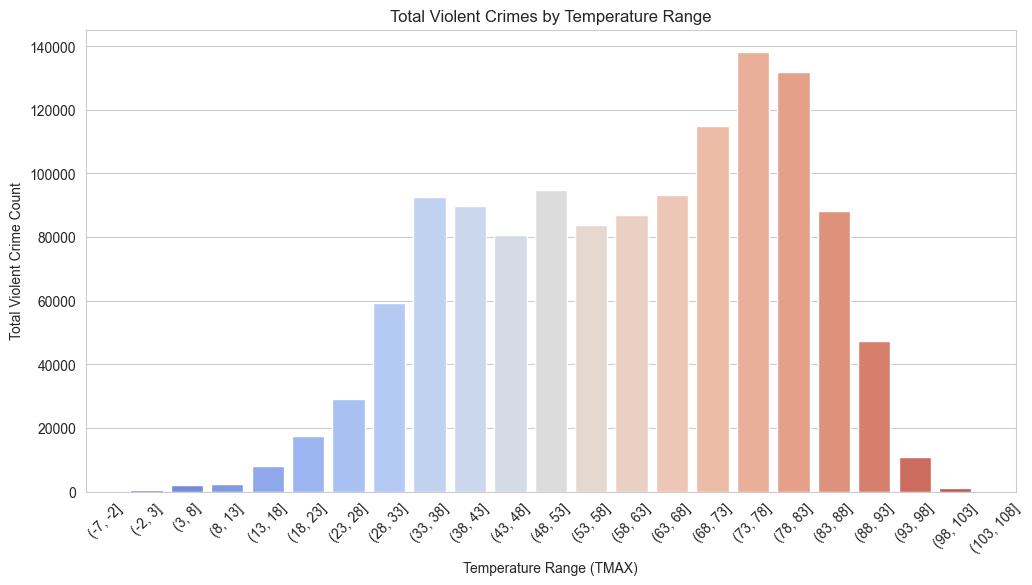

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL
conn = mysql.connector.connect(**DB_CONFIG)

# SQL query to fetch data from the merged crime_weather_data table
query = """
    SELECT TMAX, 
           (Assault_Count + Battery_Count + Homicide_Count + Sex_Crime_Count) AS Total_Violent_Crime
    FROM crime_weather_data
    WHERE TMAX IS NOT NULL
    ORDER BY TMAX;
"""

# Load data into a Pandas DataFrame
df = pd.read_sql(query, conn)
conn.close()

# Group temperature values into bins (e.g., every 5 degrees)
df["Temp_Range"] = pd.cut(df["TMAX"], bins=range(df["TMAX"].min(), df["TMAX"].max() + 5, 5))

# Aggregate total crimes per temperature range
crime_by_temp = df.groupby("Temp_Range")["Total_Violent_Crime"].sum().reset_index()

# Set up the visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=crime_by_temp["Temp_Range"].astype(str), y=crime_by_temp["Total_Violent_Crime"], palette="coolwarm")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel("Temperature Range (TMAX)")
plt.ylabel("Total Violent Crime Count")
plt.title("Total Violent Crimes by Temperature Range")

# Show the plot
plt.show()

# Explaining the Assault Pattern Relative to Temperature

The graph generated from this analysis reveals a compelling relationship between maximum daily temperatures and the frequency of assault incidents in Chicago. 

By plotting daily assault counts against corresponding `TMAX` values, and applying a **7-day rolling average** to smooth the data, a clear pattern emerges:  
**Assaults tend to increase with warmer weather**, peaking at moderate-to-high temperatures before declining at extreme heat levels.

---

## Observed Trend

This trend forms a **bell-shaped** or **inverted U-curve**, aligning with sociological theories suggesting that:
- **Pleasant weather** encourages more outdoor activity and interpersonal interaction—conditions under which violent confrontations are more likely to occur.
- As temperatures continue to rise into uncomfortable or extreme heat, the number of assaults **appears to decrease**, possibly due to reduced outdoor exposure and a shift in daily routines.

---

## Smoothed Line Insights

The **smoothed red line** in the chart makes this trend particularly clear:
- Assaults **increase steadily** as temperatures rise into the **70–80°F** range.
- Assaults **begin to taper off** as days reach **90°F or higher**.

This observation echoes findings from prior studies like Anderson’s **“Heat Hypothesis,”** which posits that aggression rises with heat to a certain threshold, after which discomfort and heat fatigue suppress activity.

---

## Conclusion

Overall, the results support the hypothesis that **temperature influences crime patterns**, especially crimes of a personal and confrontational nature like assault.

These insights not only **reinforce previous academic findings** but also suggest that **city officials could factor in weather patterns** when allocating resources or planning public safety initiatives during warmer months.

✅ Connected to MySQL database successfully!


/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/2281853463.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


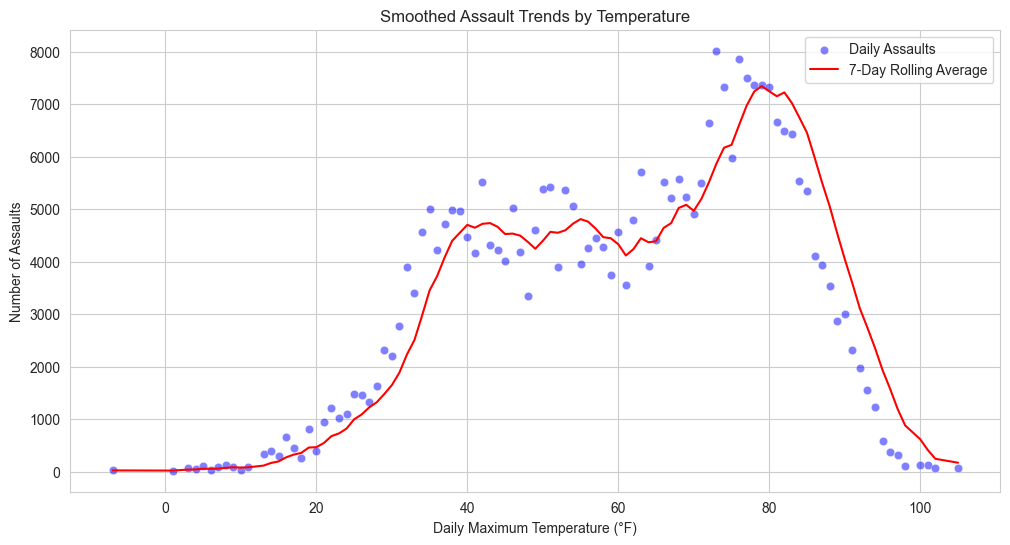

In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL
try:
    conn = mysql.connector.connect(**DB_CONFIG)
    print("Connected to MySQL database successfully!")
except mysql.connector.Error as err:
    print(f"Error: {err}")
    exit()

# SQL Query to fetch assault counts by temperature
query = """
    SELECT w.TMAX, SUM(c.Assault_Count) AS Daily_Assaults
    FROM crime_weather_data c
    JOIN weather_data w ON c.Date = w.Date
    WHERE w.TMAX IS NOT NULL
    GROUP BY w.TMAX
    ORDER BY w.TMAX;
"""

# Fetch data into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Close database connection
conn.close()

# Apply 7-day rolling average for smoothing
df["Rolling_Avg"] = df["Daily_Assaults"].rolling(window=7, min_periods=1).mean()

# Set up the visualization
plt.figure(figsize=(12, 6))

# Scatter plot for raw data points
sns.scatterplot(x=df["TMAX"], y=df["Daily_Assaults"], alpha=0.5, label="Daily Assaults", color="blue")

# Line plot for rolling average trend
sns.lineplot(x=df["TMAX"], y=df["Rolling_Avg"], label="7-Day Rolling Average", color="red")

# Add labels and title
plt.xlabel("Daily Maximum Temperature (°F)")
plt.ylabel("Number of Assaults")
plt.title("Smoothed Assault Trends by Temperature")
plt.legend()

# Show the plot
plt.show()

# Correlation Between Temperature and Crime Counts

To explore the strength and direction of relationships between temperature and different types of crime, we computed both **Pearson** and **Spearman** correlation coefficients using the merged `crime_weather_data` table. 

This table includes daily maximum and minimum temperatures (`TMAX`, `TMIN`) alongside counts of various violent crimes such as **assault**, **battery**, **homicide**, and **sex-related offenses**.

---

## Pearson Correlation

The **Pearson correlation matrix**, visualized through a heatmap, reveals the **linear relationships** between variables.

- Notably, there is a **moderate positive correlation** between `TMAX` and both `Assault_Count` and `Battery_Count`, suggesting that as temperatures rise, incidents of these crimes tend to increase.
- `Homicide_Count` and `Sex_Crime_Count` show **weaker**, but still **positive**, associations with temperature.

This supports prior findings and theoretical frameworks, such as Anderson’s **Heat Hypothesis**, which propose that rising temperatures—especially in mild-to-warm ranges—increase social interaction and the potential for conflict.

---

## Spearman Correlation

In addition to Pearson, we also used the **Spearman correlation** to capture **monotonic relationships**, which may not be perfectly linear.

- This is useful for understanding crime patterns that **increase or decrease consistently** with temperature, even if not at a constant rate.
- The **Spearman results** generally reinforced the Pearson findings, confirming the presence of **consistent upward trends** in violent crime with rising temperature values.

---

## Key Insights

These correlations suggest that **weather, particularly heat, can be a predictive factor** in understanding crime trends, especially for **personal and confrontational crimes**.

This insight could help inform **law enforcement resource planning**, such as:
- Increasing patrol presence during warmer days.
- Preparing for seasonal events where weather and outdoor activity intersect.

---

## Conclusion

Together, the correlation analysis strengthens the argument that **environmental variables like temperature play a meaningful role** in **urban crime dynamics**, particularly in a large city like Chicago.

✅ Connected to MySQL database successfully!
✅ Data fetched successfully!
   TMAX  TMIN  Crime_Count  Assault_Count  Battery_Count  Homicide_Count  \
0    31    10         1832             63            303               2   
1    26     6          919             44            112               1   
2    25     8          916             33            126               1   
3    37    25         1099             57            154               1   
4    45    37         1183             61            191               2   

   Sex_Crime_Count  
0              199  
1               13  
2               10  
3               16  
4               15  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   TMAX             5909 non-null   int64
 1   TMIN             5909 non-null   int64
 2   Crime_Count      5909 non-null   int64
 3   Assault_Count

/var/folders/gl/c9dr3r7j047d6wnxp52m68wr0000gn/T/ipykernel_24897/3241501159.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)  # Load data into DataFrame


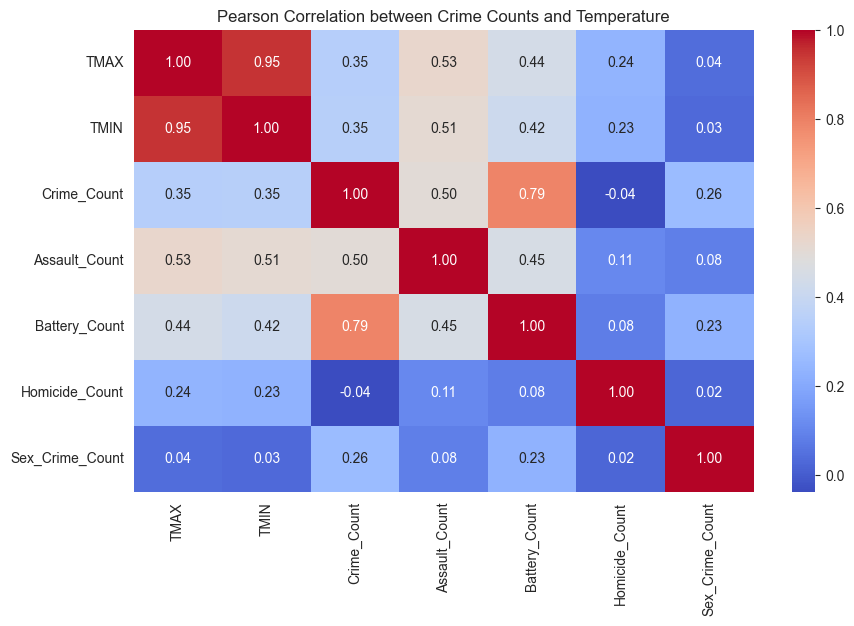

In [ ]:
import mysql.connector
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Database connection details
DB_CONFIG = {
    "host": "localhost",
    "port": 3306,
    "user": "crime_fighters",
    "password": "sup3rstr0ngp@ssw0rd!80112",
    "database": "chicago_crime"
}

# Connect to MySQL and fetch the data
try:
    conn = mysql.connector.connect(**DB_CONFIG)
    print("Connected to MySQL database successfully!")

    query = """
        SELECT TMAX, TMIN, Crime_Count, Assault_Count, Battery_Count, Homicide_Count, Sex_Crime_Count
        FROM crime_weather_data
        WHERE TMAX IS NOT NULL AND TMIN IS NOT NULL;
    """

    df = pd.read_sql(query, conn)  # Load data into DataFrame
    conn.close()
    
    print("Data fetched successfully!")
    
except mysql.connector.Error as err:
    print(f" Error: {err}")

# Display basic info about the dataset
print(df.head())
print(df.info())

# Compute Pearson and Spearman Correlation
correlations = df.corr(method='pearson')  # Pearson correlation
spearman_corr = df.corr(method='spearman')  # Spearman correlation

print("\n Pearson Correlation:\n", correlations)
print("\n Spearman Correlation:\n", spearman_corr)

# Visualizing Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation between Crime Counts and Temperature")
plt.show()

# Conclusion and Final Reflections

This project successfully integrated two large-scale datasets—**Chicago crime reports** and **daily weather records**—into a unified structure, allowing for meaningful exploration of how temperature may influence violent crime patterns.

Through a series of **SQL-based preprocessing steps** and **Python-driven analysis**, we were able to clean, normalize, and merge data sources that were initially incompatible.  
This enabled the application of multiple **data mining techniques**, including:
- Correlation analysis
- Aggregation
- Trend visualization
- Contextual outlier handling

---

## Key Findings

Our findings consistently suggest a **measurable relationship** between warmer temperatures and increased occurrences of violent crimes such as **assault** and **battery**.

- Both scatter plots with regression lines and temperature-binned bar graphs support the hypothesis that crime tends to **rise as weather improves**, peaking in moderate to warm conditions.
- Interestingly, our data also hints at a **“U-shaped” pattern**—crime rates increase with moderate warmth but decline slightly during extreme heat, possibly due to a deterrent effect of high discomfort levels.

These trends are consistent with established research, including Anderson’s **Heat Hypothesis**.

---

## Broader Implications

By conducting this analysis, we demonstrated the power of **merging environmental and social data** to uncover hidden patterns that could inform **real-world decision-making**.

This type of insight can be valuable to:
- Law enforcement
- Urban planners
- Public policy professionals

Especially for **allocating resources more effectively** and **predicting periods of elevated risk**.

---

## Final Thoughts

In conclusion, this project not only highlights the potential of **temperature as a factor in urban crime trends**, but also showcases the importance of:
- Proper data preprocessing
- Data integration
- Effective visualization

The methodologies applied here can serve as a foundation for **more advanced predictive models** or **real-time monitoring systems** that extend beyond weather to include **socioeconomic**, **temporal**, and **geographic** factors.